## 3) 求解惩罚线性回归


### 理解最小角度回归于前向逐步回归的关系

【续前】

### 理解Glmnet算法

参考了glmnet的原始论文：

Regularization Paths for Generalized Linear Models via Coordinate Descent（基于坐标下降法的广义线性模型正规化路径）, Jerome Friedman, 2010.pdf  链接: https://pan.baidu.com/s/1kUM1NCF 密码: pf25

为了理解**ElasticNet回归**的数值算法，我们先看一个更一般的优化问题:

$$\boldsymbol{\beta}^* = \underset{\boldsymbol{\beta}}{\rm{argmin}} \ J(\boldsymbol{\beta}) = \underset{\boldsymbol{\beta}}{\rm{argmin}} \left\{ f(\boldsymbol{\beta}) + (1-\alpha) \dfrac{\lambda}{2}  {\| \boldsymbol{\beta} \|}^2 + \alpha \lambda  {\| \boldsymbol{\beta} \|}_1\right\}$$

作为数值解，只要$f(\boldsymbol{\beta})$一阶可导都不是问题，问题出在${\| \boldsymbol{\beta} \|}_1$是不连续的。我们注意到，${\| \boldsymbol{\beta} \|}_1$虽然不连续，但是其变量是解耦的（对回归系数元素的某个函数（比如绝对值）之和），而${\| \boldsymbol{\beta} \|}_2$也已经是解耦的。如果我们也能把$f(\boldsymbol{\beta})$解耦，那就方便了。当然直接这样做肯定是不可能的，但我们仅仅是求数值解，可以通过迭代得到最优值，这就给了我们对$f(\boldsymbol{\beta})$进行局部近似的机会。

关于解耦，数学上有一个著名的不等式-**利普希茨(Lipschitz)条件**,存在常数$L>0$，使得:

$${\| f(\boldsymbol{x}') - f(\boldsymbol{x}) \|}_2^2 \le L {\| \boldsymbol{x}' - \boldsymbol{x} \|}^2 $$

我们注意到不等式的右边恰好就是解耦的。这个条件是一个比一致连续更强的光滑条件，一般而言在优化问题中这个条件是满足的，比如**套索回归**和**ElasticNet回归**就满足（当然已解耦的部分${\| \boldsymbol{\beta} \|}_2$和${\| \boldsymbol{\beta} \|}_1$要剔除在外）。

作为数值解，我们是通过迭代获取最优解，那么关于迭代过程中相邻的两个解$(\boldsymbol{\beta},\tilde{\boldsymbol{\beta}})$可以对$f(\boldsymbol{\beta})$进行泰勒展开，并在二阶展开项利用**利普希茨(Lipschitz)条件**得到：

$$
\begin{array}
& f(\boldsymbol{\beta}) &\simeq& f(\tilde{\boldsymbol{\beta}}) + (\nabla f(\tilde{\boldsymbol{\beta}}))^T (\boldsymbol{\beta} - \tilde{\boldsymbol{\beta}}) + \dfrac{L}{2} {\|\boldsymbol{\beta} - \tilde{\boldsymbol{\beta}}\|}^2 \\
&=& \dfrac{L}{2} {\|\boldsymbol{\beta}-(\tilde{\boldsymbol{\beta}} - \dfrac{1}{L} \nabla f(\tilde{\boldsymbol{\beta}}))\|}^2 + const \\
&=& \dfrac{L}{2} {\|\boldsymbol{\beta}-\tilde{\boldsymbol{z}} \|}^2 + const, \quad \tilde{\boldsymbol{z}} =\tilde{\boldsymbol{\beta}} - \dfrac{1}{L} \nabla f(\tilde{\boldsymbol{\beta}})
\end{array}
$$

进而得到一个局部的，完全解耦的最优问题(同时将$L$吸收到$\lambda$中去)：

$$\tilde{\boldsymbol{\beta}} \leftarrow \underset{\boldsymbol{\beta}}{\rm{argmin}} \left\{\dfrac{1}{2} {\|\boldsymbol{\beta}-\tilde{\boldsymbol{z}} \|}^2 + (1-\alpha) \dfrac{\lambda}{2}  {\| \boldsymbol{\beta} \|}^2 + \alpha \lambda  {\| \boldsymbol{\beta} \|}_1\right\}, \quad \tilde{\boldsymbol{z}} = \tilde{\boldsymbol{\beta}} - \nabla f(\tilde{\boldsymbol{\beta}})$$

对应的目标函数的一阶导数(可以分段求导)都是完全解耦的方程组，进而可以得到一个封闭解：

$$ \tilde{\beta}_j \leftarrow \dfrac{\tilde{z}_j - \lambda \alpha \dfrac{\partial}{\partial \tilde{\beta}_j} |\tilde{\beta}_j|}{1+\lambda (1-\alpha)} , \quad \tilde{z}_j = \tilde{\beta}_j - (\nabla f(\tilde{\boldsymbol{\beta}}))_j, \quad j=1,\dots,n$$

可以写成分段形式$S(z,g)$，称之为**套索系数的缩减函数**：

$$
S(z,g) = \left\{
\begin{array} 
&z-g, &z > g \\
0, &|z| \le g\\
z+g, &z < -g
\end{array} 
\right. \quad g>0
$$

$$
\tilde{\beta}_j \leftarrow \dfrac{S(\tilde{z}_j,\lambda \alpha)}{1+ \lambda (1-\alpha)}
$$

特别地，**ElasticNet线性回归**而言：

$$
\tilde{z}_j = \tilde{\beta}_j - (\nabla f(\tilde{\boldsymbol{\beta}}))_j = \tilde{\beta}_j + \dfrac{1}{m} \boldsymbol{x}_j^T (\boldsymbol{y} - \boldsymbol{X} \tilde{\boldsymbol{\beta}}), \quad \boldsymbol{x}_j = \boldsymbol{X}(:,j)
$$

进而可写出**ElasticNet递归公式**：

$$
\tilde{\beta}_j \leftarrow \dfrac{S(\tilde{\beta}_j + \frac{1}{m} \boldsymbol{x}_j^T(\boldsymbol{y}-\boldsymbol{X}\tilde{\boldsymbol{\beta}}),\lambda \alpha)}{1+ \lambda (1-\alpha)}
$$

再特别一点$\alpha=1$，就是**套索递归公式**：

$$\tilde{\beta}_j \leftarrow S(\tilde{\beta}_j + \dfrac{1}{m} \boldsymbol{x}_j^T(\boldsymbol{y}-\boldsymbol{X}\tilde{\boldsymbol{\beta}}),\lambda)$$


**ElasticNet递归公式**对应的算法就是**Glmnet算法**。

【注意】，**ElasticNet递归公式**写成了分量和向量形式的混杂， 这意味着：在计算过程中回归系数$\tilde{\beta}_j$会立刻更新（即，下一个回归系数$\tilde{\beta}_{j+1}$会用到已经更新的$\tilde{\beta}_k, k\le j$），这种更新方式称为**异步更新**。另一种更新模式是**同步更新**，这种方式的递推公式可以写成全向量形式。

下面依然是手写的代码实现（没用算法包）：

酒精含量
挥发性酸
亚硝酸盐
总二氧化硫
氯化物
非挥发性酸
PH值
游离二氧化硫
残留糖分
柠檬酸
密度


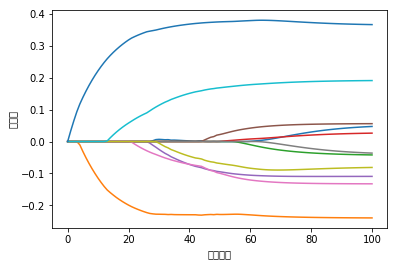

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def S(z, gamma):
    '''
        套索系数的缩减函数
    '''
    
    if gamma >= abs(z):
        return 0.0
    return (z/abs(z))*(abs(z) - gamma)

def elasticNetRecursive(xx, y, beta, lam, alp):
    '''
        ElasticNet单步递归
    参数：
        xx:  属性矩阵X
        y:   标签向量
        beta: 回归系数向量(更新后返回)
        lam:  \lambda
        alp:  \alpha
    '''
    
    m,n = xx.shape
    
    # 回归系数\beta的元素逐个更新
    for j in range(n):
        resi = y - xx.dot(beta)
        z = beta[j] + resi.dot(xx[:,j])/m
        beta[j] = S(z, lam*alp) / (1+lam*(1-alp))
    
    return beta

# 获取红酒数据集
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(target_url, header=0, sep=";")
df.columns = ['非挥发性酸','挥发性酸','柠檬酸', '残留糖分', '氯化物', '游离二氧化硫','总二氧化硫', '密度', 
              'PH值', '亚硝酸盐', '酒精含量', '品质']

# 标准化
norm_df = (df - df.mean())/df.std()
xData = norm_df.values[:,:-1]; yData = norm_df.values[:,-1] 


# 选择alpha参数
alpha = 1.0  # 套索线性回归

# 确定lambda初始值：导致所有beta值都为零的lambda值（最简模型）
lam = (np.abs(yData.dot(xData))/xData.shape[0]).max()/alpha

# beta初始化
beta = np.zeros(xData.shape[1])

# 记录历史beta
betaMat = []
betaMat.append(list(beta))

# 迭代步数
nSteps = 100 #56 #100

# lambda缩减乘子：Fredman建议每步迭代后都要稍微减小lambda
lamMult = 0.93 # Fredman建议: lamMult^nSteps = 0.001

# 记录属性回归系数变成非零先后次序
nzList = []

# 开始进行lam迭代计算
for iStep in range(nSteps):
    lam = lam * lamMult
    
    deltaBeta = 100.0
    eps = 0.01
    iterStep = 0
    
    # 开始Glmnet算法迭代
    while deltaBeta > eps:
        iterStep += 1
        if iterStep > 100: #100:
            break
        
        # 上一步beta
        _beta = beta.copy()

        # ElasticNet递归公式
        beta = elasticNetRecursive(xData, yData, beta, lam, alpha)
        
        # 计算精度
        deltaBeta = np.abs(beta-_beta).sum() / np.abs(beta).sum()
    
    # print (iStep, iterStep)
    
    # 记录beta历史
    betaMat.append(list(beta))

    # 记录回归系数刚好变成非零的属性
    nzBeta = np.where(beta!=0)[0]
    for q in nzBeta:
        if (q in nzList) == False:
            nzList.append(q)

# 打印属性重要性排序
for idx in nzList:
    print (df.columns[idx])

# lambda-误差曲线
plt.plot(betaMat)
plt.xlabel("迭代步数")
plt.ylabel("系数值")
plt.show()

### 套索惩罚项的另一种解法

Glmnet算法的特点是：将$f(\boldsymbol{\beta})$解耦成${\|\boldsymbol{\beta}-\tilde{\boldsymbol{z}} \|}^2$的形式。

这里介绍的算法是：将非线性的**套索惩罚项**用其上界**二次函数族**来夹逼.

当然，我们依旧是在数值迭代中用**二次函数族**来夹逼近似：

$$\left| \beta_j \right| \le \dfrac{\beta_j^2}{2 c_j} + \dfrac{c_j}{2} \quad c_j>0$$

既然是数值解法，我们可以选择某个组${c_j}$作为$\beta_j$的初值，然后反复用计算后的$\left| \beta_j \right|$更新${c_j}$，进而将**二次函数**惩罚项逼向**绝对值**惩罚项， 于是可以改写成：

$$\left| \beta_j \right| \le \dfrac{\beta_j^2}{2 \left| \tilde{\beta}_j \right|}  + \dfrac{\left| \tilde{\beta}_j \right|}{2}$$

进而(由于数值解$\tilde{\boldsymbol{\beta}}$可能接近0，所以$\tilde{\boldsymbol{B}}^{\dagger}$指的是**广义逆**)：
$$
\begin{array}
&{\| \boldsymbol{\beta} \|}_1 \le \dfrac{1}{2} \boldsymbol{\beta}^T \tilde{\boldsymbol{B}}^{\dagger} \boldsymbol{\beta} + C \\
\tilde{\boldsymbol{B}} = \rm{diag} (\left| \tilde{\beta}_1 \right|, \dots, \left| \tilde{\beta}_n \right|)
\end{array}
$$

于是得到原优化问题的，局部的，临时的，上界优化问题：

$$ \hat{\boldsymbol{\beta}} = \underset{\boldsymbol{\beta}}{\rm{argmin}} \ J(\boldsymbol{\beta}) = \underset{\boldsymbol{\beta}}{\rm{argmin}} \left\{ \dfrac{1}{2m} \|\boldsymbol{y}-\boldsymbol{X} \boldsymbol{\beta}\|^2 + (1-\alpha) \dfrac{\lambda}{2}  {\| \boldsymbol{\beta} \|}^2 + \alpha \dfrac{\lambda}{2} \boldsymbol{\beta}^T \tilde{\boldsymbol{B}}^{\dagger} \boldsymbol{\beta} \right\}$$

采用岭回归类似的步骤，可以得到一个局部的，临时的封闭解：

$$\hat{\boldsymbol{\beta}} = (\boldsymbol{X}^T \boldsymbol{X} + (1-\alpha) \lambda \boldsymbol{I}+ \alpha \lambda \tilde{\boldsymbol{B}}^{\dagger})^{-1} \boldsymbol{X}^T \boldsymbol{y}$$

然后把这个解$\hat{\boldsymbol{\beta}}$作为$\tilde{\boldsymbol{\beta}}$反复前面的流程，直到$\hat{\boldsymbol{\beta}}$达到收敛精度。

这个算法的更新方式是**同步更新**，所以递推公式可以写成全向量形式。

下面是手写演示代码：

In [18]:
xData.shape[1]

11

In [23]:
# 继续利用前面的数据
###原有环境使用的是python2，换成python3后修改相应代码之后不知道是不是包方面有改变导致无法运行
idxs = range(len(yData))
test_rang = map(lambda i:i%3==0, idxs)
train_rang = map(lambda i:i%3!=0, idxs)
xTest = xData[test_rang]; yTest = yData[test_rang]
xTrain = xData[train_rang]; yTrain = yData[train_rang]

# 选择alpha参数
alpha = 1.0  # 套索线性回归

# 选择alpha列表（一般按10的倍数递减）
lamList = [0.1**i for i in range(7)]

rmsError = []
betaList=[]
for lam in lamList:   
    # 回归系数\beta向量初始化
    beta = np.random.randn(xTrain.shape[1])

    # 训练
    for i in range(1000): 
        # 根据 迭代公式 计算
        tmp = xTrain.T.dot(xTrain) + \
                (1-alpha)*lam * np.diag(np.ones(xTrain.shape[1])) + \
                alpha*lam*np.linalg.pinv(np.diag(np.abs(beta)))
        _beta = np.linalg.inv(tmp).dot(xTrain.T).dot(yTrain)
        _err = (_beta - beta)
        beta = _beta
        # 判断是否达到收敛精度
        if (_err**2).sum()<0.00001:
            break
    # 记录beta
    betaList.append(list(beta))
    # 测试集上误差评估  
    rmsError.append(np.linalg.norm(yTest-xTest.dot(beta), 2) / sqrt(len(yTest)))


print ("lam对应的RMS误差：",)
for i in range(len(rmsError)):
    print ("(%s,%s)"%(lamList[i],rmsError[i])) 

# lambda-误差曲线
plt.plot(rmsError, 'k')
plt.xlabel("-log(alpha)")
plt.ylabel("误差(RMS)")
plt.show()

# 最佳模型
idx = np.argmin(rmsError)
lamBest = lamList[idx]
betaBest = np.array(betaList[idx])
print ("最佳lambda：", lamBest)
print ("最佳beta：", betaBest)

# 预测 与 实际 的散点图
plt.scatter(xTest.dot(betaBest), yTest, s=100, alpha=0.1)
plt.xlabel("预测口感得分")
plt.ylabel("实际口感得分")
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices